In [1]:
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
import os
from typing import TypedDict
from langchain_groq import ChatGroq
load_dotenv()

c:\Users\Nitro\Desktop\Desk\CampusX\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


True

In [2]:
class BatsManState(TypedDict):
    runs : int
    balls : int
    fours : int
    sixs : int
    sr : float
    run_in_boundary : float
    bpb : float
    summary : str

In [3]:
def calculate_sr(state: BatsManState) -> BatsManState:
    sr = (state['runs']/state['balls'])/100
    return {'sr' : sr}

def bpb(state : BatsManState) -> BatsManState:
    bpb = state['balls']/(state['fours'] + state['sixs'])
    return {'bpb' : bpb}

def rib(state : BatsManState) -> BatsManState:
    run_in_boundary =  ((state['fours'] * 4 + state['sixs'] * 6)/state['runs'])*100
    return {'run_in_boundary': run_in_boundary}

def summary(state : BatsManState) -> BatsManState:
    summary = f"sr : {state['sr']} \n runs_in_boundary : {state['run_in_boundary']} \n ball per boundary : {state['bpb']}"
    return {'summary' : summary}
    

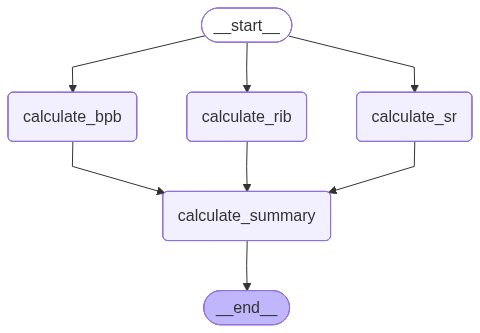

In [4]:
graph = StateGraph(BatsManState)

graph.add_node("calculate_sr", calculate_sr)
graph.add_node("calculate_rib", rib)
graph.add_node("calculate_bpb", bpb)
graph.add_node("calculate_summary", summary)

graph.add_edge(START, "calculate_sr")
graph.add_edge(START, "calculate_rib")
graph.add_edge(START, "calculate_bpb")
graph.add_edge("calculate_sr", "calculate_summary")
graph.add_edge("calculate_rib","calculate_summary")
graph.add_edge("calculate_bpb", "calculate_summary")

workflow = graph.compile()
workflow

In [5]:
print(workflow.invoke({'runs': 1, 'balls' : 2, 'fours' : 1, 'sixs' : 1})['summary'])

sr : 0.005 
 runs_in_boundary : 1000.0 
 ball per boundary : 1.0


In [6]:
# parallel workflow but using llm

llm = ChatGroq(
    model=os.getenv("model"),
    api_key=os.getenv("api_key")
)

In [7]:
class DescribeState(TypedDict):
    title: str
    llm1 : str
    llm2 : str
    summary : str

In [11]:
def llm1(state : DescribeState) -> DescribeState:
    llm1 = llm.invoke(f"Define the folowiing title in layman's way, title : {state['title']}").content
    return {'llm1' : llm}

def llm2(state : DescribeState) -> DescribeState:
    llm2 = llm.invoke(f"Give me the proper defination of the following title : {state['title']}").content
    return {'llm2' : llm2}

def summary(state : DescribeState) -> DescribeState:
    summary = llm.invoke(f"based on the layman defination: \n{state['llm1']} \nand the actual defination: {state['llm2']}, \ngive me defination in summary containing both the context of the above defination.")
    state['summary'] = summary
    return state

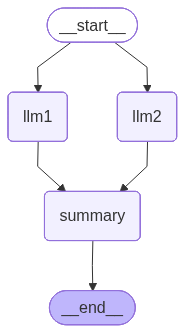

In [12]:
graph = StateGraph(DescribeState)

graph.add_node("llm1",llm1)
graph.add_node("llm2",llm2)
graph.add_node("summary", summary)

graph.add_edge(START, "llm1")
graph.add_edge(START, "llm2")
graph.add_edge("llm1", "summary")
graph.add_edge("llm2", "summary")
graph.add_edge("summary", END)

workflow = graph.compile()

workflow

In [13]:
print(workflow.invoke({'title' : "Activation function"})['summary'])

content="**Activation Function (summary)**  \n\nIn an artificial neural network, each neuron first computes a linear combination of its inputs  \n\n\\[\nz = \\mathbf{w}^{\\top}\\mathbf{x}+b ,\n\\]\n\nwhere **x** is the input vector, **w** the weight vector, and **b** the bias.  \nThe *activation function*\u202f\\( \\phi(\\cdot) \\) then transforms this pre‑activation\u202f\\(z\\) into the neuron's final output  \n\n\\[\na = \\phi(z).\n\\]\n\n**Why it matters** – The activation function injects non‑linearity, allowing the network to model complex, non‑linear patterns instead of just straight‑line (linear) relationships. Without it, any deep stack of layers would collapse to an equivalent single linear model.\n\n**Common choices** (each with a simple formula and typical use):\n\n| Function | Formula | Typical role |\n|----------|---------|--------------|\n| **Sigmoid** | \\(\\sigma(z)=\\frac{1}{1+e^{-z}}\\) | Outputs probabilities for binary classification |\n| **Tanh** | \\(\\tanh(z)=\\